# Pipeline Project

You will be using the provided data to create a machine learning model pipeline.

You must handle the data appropriately in your pipeline to predict whether an
item is recommended by a customer based on their review.
Note the data includes numerical, categorical, and text data.

You should ensure you properly train and evaluate your model.

## The Data

The dataset has been anonymized and cleaned of missing values.

There are 8 features for to use to predict whether a customer recommends or does
not recommend a product.
The `Recommended IND` column gives whether a customer recommends the product
where `1` is recommended and a `0` is not recommended.
This is your model's target/

The features can be summarized as the following:

- **Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.
- **Age**: Positive Integer variable of the reviewers age.
- **Title**: String variable for the title of the review.
- **Review Text**: String variable for the review body.
- **Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.
- **Division Name**: Categorical name of the product high level division.
- **Department Name**: Categorical name of the product department name.
- **Class Name**: Categorical name of the product class name.

The target:
- **Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.

## Load Data

## Import libraries and Requirement things :

#### Configure a NLP

In [43]:
!pip install spacy


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [44]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 89.1 MB/s eta 0:00:0000:010:01

[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [45]:
pip install -U nltk


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [46]:
pip install wordcloud


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [47]:
import spacy

In [48]:
pip install xgboost


[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:
nlp = spacy.load("en_core_web_sm")

#### Import Libraries :

In [67]:
#!/usr/bin/env python
# coding: utf-8

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import spacy
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction import DictVectorizer
import joblib
import warnings
warnings.filterwarnings('ignore')
import nltk
from sklearn.preprocessing import FunctionTransformer

# Download the missing resource
nltk.download('punkt_tab')
# Download nltk punkt
nltk.download('punkt')

# Load SpaCy model
try:
    nlp = spacy.load('en_core_web_sm')
except OSError:
    import subprocess, sys
    subprocess.run([sys.executable, "-m", "spacy", "download", "en_core_web_sm"])
    nlp = spacy.load('en_core_web_sm')


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /home/student/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [51]:
# Load data
df = pd.read_csv('data/reviews.csv')
df.info()
df.head()

# Separate features and target
X = df.drop('Recommended IND', axis=1)
y = df['Recommended IND'].copy()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18442 entries, 0 to 18441
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              18442 non-null  int64 
 1   Age                      18442 non-null  int64 
 2   Title                    18442 non-null  object
 3   Review Text              18442 non-null  object
 4   Positive Feedback Count  18442 non-null  int64 
 5   Division Name            18442 non-null  object
 6   Department Name          18442 non-null  object
 7   Class Name               18442 non-null  object
 8   Recommended IND          18442 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 1.3+ MB


## Preparing features (`X`) & target (`y`)

In [52]:
data = df

# separate features from labels
X = df.drop('Recommended IND', axis=1)
y = df['Recommended IND'].copy()

print('Labels:', y.unique())
print('Features:')
display(X.head())

Labels: [0 1]
Features:


,Clothing ID,Age,Title,Review Text,Positive Feedback Count,Division Name,Department Name,Class Name
0,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,0,General,Dresses,Dresses
1,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",0,General Petite,Bottoms,Pants
2,847,47,Flattering shirt,This shirt is very flattering to all due to th...,6,General,Tops,Blouses
3,1080,49,Not for the very petite,"I love tracy reese dresses, but this one is no...",4,General,Dresses,Dresses
4,858,39,Cagrcoal shimmer fun,I aded this in my basket at hte last mintue to...,1,General Petite,Tops,Knits


# Text Preprocessing 

In [53]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

X['Review Text'] = X['Review Text'].apply(preprocess_text)


In [54]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=True, random_state=27)

# Combined text for some pipelines
X_train['Full_Review'] = X_train['Title'].fillna('') + ' ' + X_train['Review Text'].fillna('')
X_test['Full_Review'] = X_test['Title'].fillna('') + ' ' + X_test['Review Text'].fillna('')


## Data exploration

### Target Variable Analysis

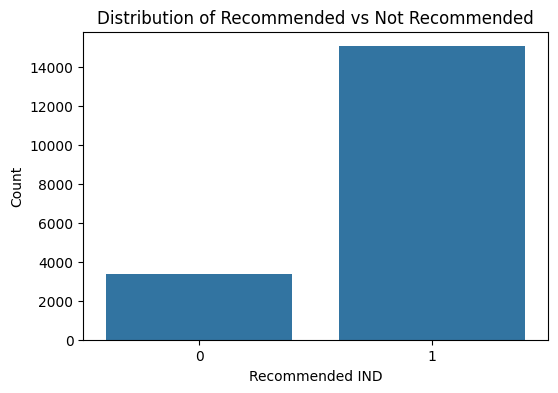

Class distribution:
Recommended IND
1    15053
0     3389
Name: count, dtype: int64

Class percentage:
Recommended IND
1    81.623468
0    18.376532
Name: proportion, dtype: float64


In [55]:
# Distribution of recommendations
plt.figure(figsize=(6, 4))
sns.countplot(x=y)
plt.title('Distribution of Recommended vs Not Recommended')
plt.xlabel('Recommended IND')
plt.ylabel('Count')
plt.show()

# Class balance
print("Class distribution:")
print(y.value_counts())
print("\nClass percentage:")
print(y.value_counts(normalize=True)*100)


### Numerical Feature Analysis

,Age,Positive Feedback Count
count,18442.000000,18442.000000
mean,43.383635,2.697484
std,12.246264,5.942220
min,18.000000,0.000000
25%,34.000000,0.000000
50%,41.000000,1.000000
75%,52.000000,3.000000
max,99.000000,122.000000


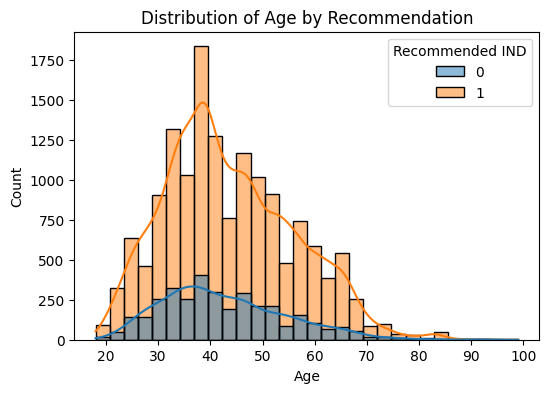

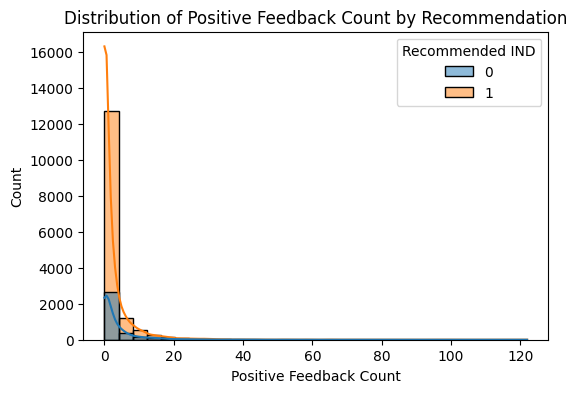

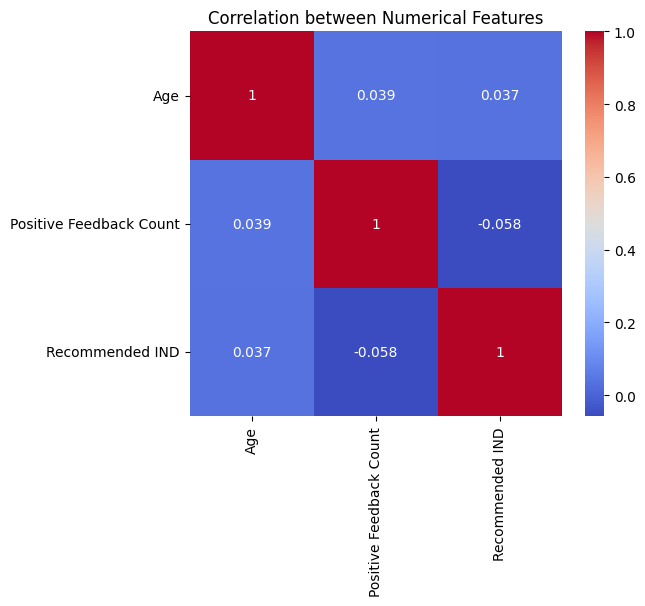

In [56]:
numerical_features = ['Age', 'Positive Feedback Count']
df_plot = X[numerical_features].copy()
df_plot['Recommended IND'] = y
# Summary statistics
display(X[numerical_features].describe())

# Histograms
for feature in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df_plot, x=feature, hue='Recommended IND', bins=30, alpha=0.5, kde=True)
    plt.title(f'Distribution of {feature} by Recommendation')
    plt.show()

# Correlation heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(df_plot.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation between Numerical Features')
plt.show()


### Categorical Feature Analysis

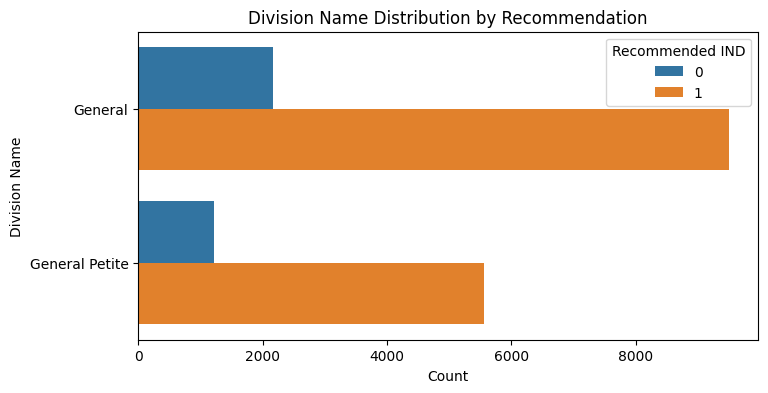

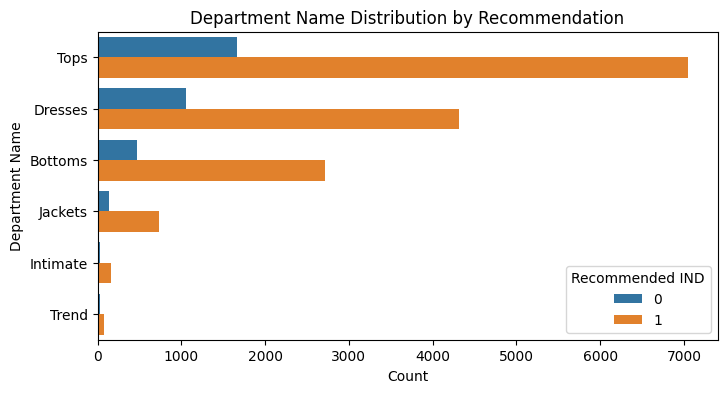

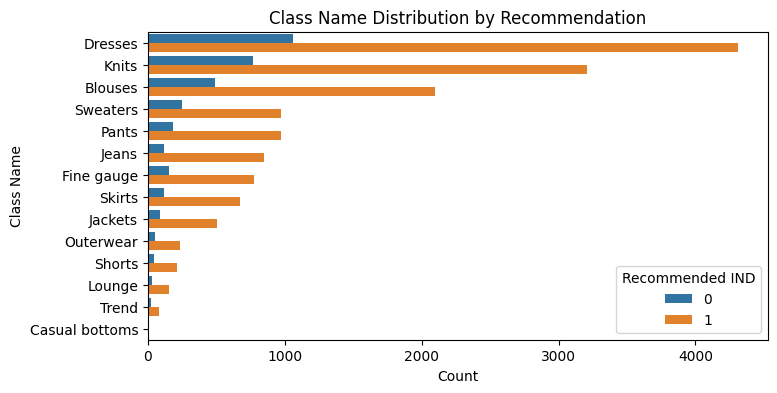

In [57]:
categorical_features = ['Division Name', 'Department Name', 'Class Name']

for feature in categorical_features:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=X, y=feature, hue=y, order=X[feature].value_counts().index)
    plt.title(f'{feature} Distribution by Recommendation')
    plt.xlabel('Count')
    plt.ylabel(feature)
    plt.show()


### Text Feature Exploration

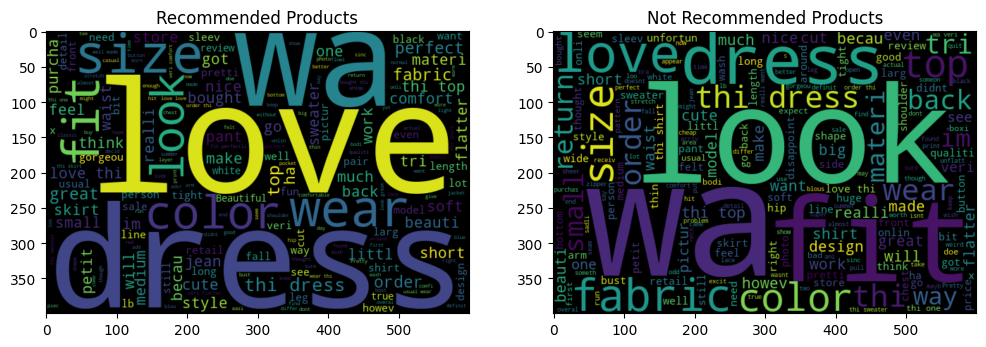

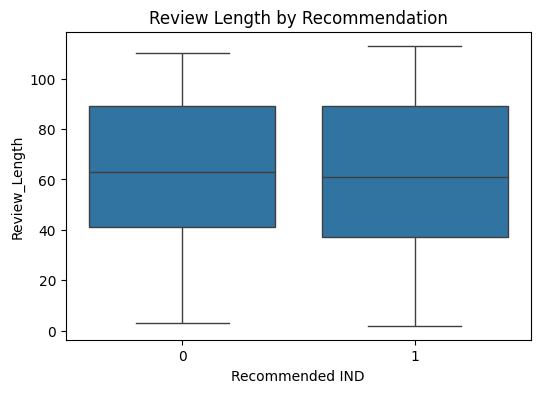

In [58]:
# Create a combined review column
X['Full_Review'] = X['Title'].fillna('') + ' ' + X['Review Text'].fillna('')

# Word cloud for recommended vs not recommended
from wordcloud import WordCloud

recommended_text = ' '.join(X[y==1]['Full_Review'])
not_recommended_text = ' '.join(X[y==0]['Full_Review'])

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
WordCloud(width=600, height=400, background_color='white').generate(recommended_text)
plt.imshow(WordCloud(width=600, height=400).generate(recommended_text), interpolation='bilinear')
plt.title('Recommended Products')

plt.subplot(1, 2, 2)
WordCloud(width=600, height=400, background_color='white').generate(not_recommended_text)
plt.imshow(WordCloud(width=600, height=400).generate(not_recommended_text), interpolation='bilinear')
plt.title('Not Recommended Products')

plt.show()

# Review length distribution
X['Review_Length'] = X['Review Text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(6, 4))
sns.boxplot(x=y, y=X['Review_Length'])
plt.title('Review Length by Recommendation')
plt.show()


### Feature Relationships

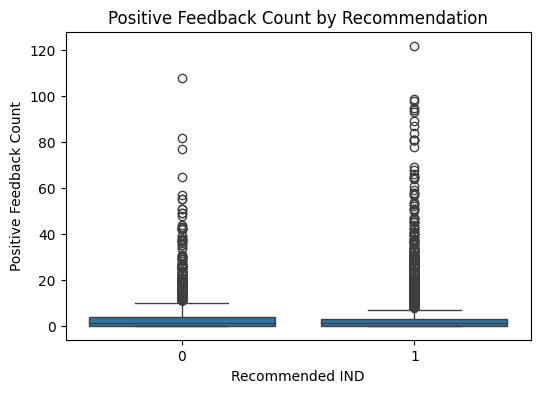

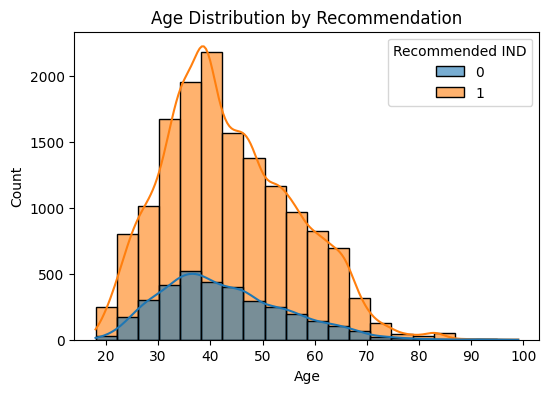

In [59]:
# Positive feedback vs recommendation
plt.figure(figsize=(6, 4))
sns.boxplot(x=y, y=X['Positive Feedback Count'])
plt.title('Positive Feedback Count by Recommendation')
plt.show()

# Age distribution vs recommendation
plt.figure(figsize=(6, 4))
sns.histplot(data=X, x='Age', hue=y, bins=20, kde=True, alpha=0.6)
plt.title('Age Distribution by Recommendation')
plt.show()


## POS and Named Entity Feature Extraction

In [60]:
def extract_pos_ner_counts(text):
    doc = nlp(text)
    pos_counts = {token.pos_: 0 for token in doc}
    entity_counts = {ent.label_: 0 for ent in doc.ents}
    for token in doc:
        pos_counts[token.pos_] += 1
    for ent in doc.ents:
        entity_counts[ent.label_] += 1
    return {"pos_counts": pos_counts, "entity_counts": entity_counts}

X_train['POS Counts'] = X_train['Review Text'].apply(lambda x: extract_pos_ner_counts(x)['pos_counts'])
X_train['Entity Counts'] = X_train['Review Text'].apply(lambda x: extract_pos_ner_counts(x)['entity_counts'])
X_test['POS Counts'] = X_test['Review Text'].apply(lambda x: extract_pos_ner_counts(x)['pos_counts'])
X_test['Entity Counts'] = X_test['Review Text'].apply(lambda x: extract_pos_ner_counts(x)['entity_counts'])


### SpaCy Text Transformer (for advanced NLP in pipeline)

In [61]:
class SpacyTextProcessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        texts = X.iloc[:, 0].astype(str).tolist() if isinstance(X, pd.DataFrame) else [str(x) for x in X]
        processed_docs = []
        for text in texts:
            doc = self.nlp(text.lower())
            tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
            processed_docs.append(' '.join(tokens))
        return processed_docs


### Preprocessing Pipelines

In [62]:
numeric_features = ['Age', 'Positive Feedback Count']
categorical_features = ['Clothing ID', 'Division Name', 'Department Name', 'Class Name']
text_features = ['Full_Review']

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

text_transformer = Pipeline([
    ('selector', FunctionTransformer(lambda x: x[['Full_Review']], validate=False)),
    ('preprocessor', SpacyTextProcessor()),
    ('vectorizer', TfidfVectorizer(max_features=3000, min_df=2, max_df=0.85, ngram_range=(1,2)))
])

pos_transformer = Pipeline([('vectorizer', DictVectorizer(sparse=False))])
entity_transformer = Pipeline([('vectorizer', DictVectorizer(sparse=False))])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('text', text_transformer, text_features),
    ('pos', pos_transformer, 'POS Counts'),
    ('entity', entity_transformer, 'Entity Counts')
], remainder='drop')


### Define Pipelines for Random Forest & XGBoost

In [63]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=27, class_weight='balanced', n_jobs=-1))
])

xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=27, n_jobs=-1))
])


### Train & Evaluate Models

In [64]:
rf_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Predictions
rf_preds = rf_pipeline.predict(X_test)
xgb_preds = xgb_pipeline.predict(X_test)

print("Random Forest Classification Report:")
print(classification_report(y_test, rf_preds))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_preds))


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.36      0.49       327
           1       0.88      0.98      0.92      1518

    accuracy                           0.87      1845
   macro avg       0.83      0.67      0.71      1845
weighted avg       0.86      0.87      0.85      1845

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.47      0.58       327
           1       0.89      0.97      0.93      1518

    accuracy                           0.88      1845
   macro avg       0.82      0.72      0.75      1845
weighted avg       0.87      0.88      0.87      1845



## Hyperparameter Tuning

In [ ]:
# Randomized search for Random Forest
rf_param_dist = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
}

rf_random_search = RandomizedSearchCV(
    rf_pipeline,         # your pipeline with RandomForestClassifier
    param_distributions=rf_param_dist,
    n_iter=10,           # test 10 random combinations only
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=27
)

rf_random_search.fit(X_train, y_train)
best_rf_model = rf_random_search.best_estimator_
print("Best RF params:", rf_random_search.best_params_)

# Randomized search for XGBoost
xgb_param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 6, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 0.9, 1.0],
}

xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,        # your pipeline with XGBClassifier
    param_distributions=xgb_param_dist,
    n_iter=10,           # test 10 random combinations only
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=27
)

xgb_random_search.fit(X_train, y_train)
best_xgb_model = xgb_random_search.best_estimator_
print("Best XGB params:", xgb_random_search.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


# Feature Importance Analysis (numeric, categorical, text contributions)

In [ ]:
def analyze_feature_importance(model, numeric_features, categorical_features, text_features):
    importances = model.named_steps['classifier'].feature_importances_
    preprocessor = model.named_steps['preprocessor']
    cat_features = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    text_features_names = preprocessor.named_transformers_['text'].named_steps['vectorizer'].get_feature_names_out()
    all_features = list(numeric_features) + list(cat_features) + list(text_features_names)
    
    numeric_idx = [i for i,f in enumerate(all_features) if f in numeric_features]
    cat_idx = [i for i,f in enumerate(all_features) if f in cat_features]
    text_idx = [i for i,f in enumerate(all_features) if f in text_features_names]
    
    importance_by_type = {
        'Numeric': np.sum(importances[numeric_idx]),
        'Categorical': np.sum(importances[cat_idx]),
        'Text': np.sum(importances[text_idx])
    }
    total = sum(importance_by_type.values())
    for k in importance_by_type:
        importance_by_type[k] = (importance_by_type[k]/total)*100
    return importance_by_type

rf_importance = analyze_feature_importance(best_rf_model, numeric_features, categorical_features, text_features)
xgb_importance = analyze_feature_importance(best_xgb_model, numeric_features, categorical_features, text_features)




## Save Best Model

In [ ]:
joblib.dump(best_rf_model, 'best_rf_pipeline.pkl')
joblib.dump(best_xgb_model, 'best_xgb_pipeline.pkl')
print("Pipelines saved successfully.")
